In [1]:
import tensorflow as tf
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# Define directory containing all your data
data_dir = r"E:\MAIN PROJECT\FILTERD CODES\data splitting\scalogram data\PCG_scalogram_divided"

# Define image dimensions
target_size = (224, 224)

batch_size = 64

# Create data generator with augmentation for training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Set up data generators for training, validation, and test sets

# Create data generator for training data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Shuffle the data
    subset='training'  # Use training subset
)

# Create data generator for validation data
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Do not shuffle the data for validation
    subset='validation'  # Use validation subset
)


Found 2782 images belonging to 2 classes.
Found 695 images belonging to 2 classes.


In [2]:
import tensorflow as tf

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + tf.keras.backend.epsilon()))

In [3]:
# Load pre-trained GoogleNet model without the top (classification) layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Add custom top layers for your binary classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Combine base model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score])

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    filepath="E:\MAIN PROJECT\\FILTERD CODES\\data splitting\\trained models\\GoogLeNet\\GoogLeNet_PCG\\GoogLeNet_PCG_epoch_{epoch:02d}.keras",  # Save the model with the epoch number in the filename
    save_weights_only=False,  # Save the entire model (architecture, weights, and training configuration)
    save_best_only=False,  # Save the model after each epoch, regardless of performance
    monitor='val_loss',  # Quantity to monitor on the validation set
    mode='min',  # Mode can be 'min' or 'max' depending on whether you want to minimize or maximize the monitored quantity
    verbose=1
)


# Define a callback for early stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Quantity to monitor on the validation set
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# Train the model using data generators
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, early_stopping_callback]

)

Epoch 1/100


44/44 [==============================] - ETA: 0s - loss: 1.2341 - accuracy: 0.6715 - precision: 0.1364 - recall: 0.1037 - f1_score: 0.1115
Epoch 1: saving model to E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\GoogLeNet\GoogLeNet_PCG\GoogLeNet_PCG_epoch_01.keras
44/44 [==============================] - 209s 4s/step - loss: 1.2341 - accuracy: 0.6715 - precision: 0.1364 - recall: 0.1037 - f1_score: 0.1115 - val_loss: 76750.9141 - val_accuracy: 0.7108 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.7110 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 2: saving model to E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\GoogLeNet\GoogLeNet_PCG\GoogLeNet_PCG_epoch_02.keras
44/44 [==============================] - 196s 4s/step - loss: 0.6551 - accuracy: 0.7110 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_

In [3]:
from tensorflow.keras.models import load_model
GoogLeNet_PCG = load_model(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\GoogLeNet\GoogLeNet_PCG\GoogLeNet_PCG_epoch_13.keras",custom_objects={'precision': precision, 'recall': recall, 'f1_score': f1_score})

44/44 [==============================] - 57s 1s/step


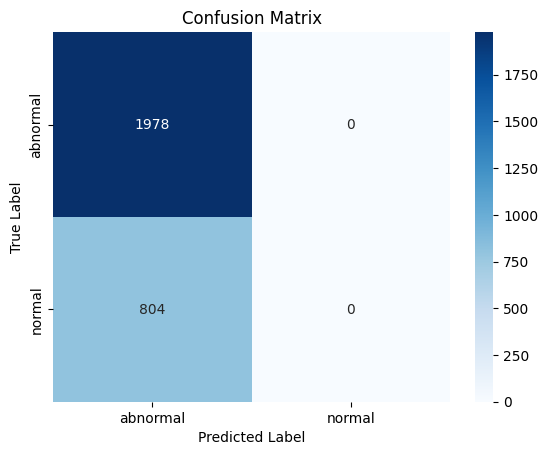

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1978
           1       0.00      0.00      0.00       804

    accuracy                           0.71      2782
   macro avg       0.36      0.50      0.42      2782
weighted avg       0.51      0.71      0.59      2782



c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have a trained model named 'model' and validation generator 'val_generator'

# Predict the labels on the validation set
y_true_train = train_generator.classes
y_pred_prob_train= GoogLeNet_PCG.predict(train_generator)
y_pred_train = np.round(y_pred_prob_train)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
cm_train = confusion_matrix(y_true_train, y_pred_train)

# Visualize the confusion matrix with values
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['abnormal', 'normal'], yticklabels=['abnormal', 'normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_train, y_pred_train))

In [5]:
# Assuming the classes are labeled as 0 and 1
class_0_probabilities = y_pred_prob_train[:, 0]  # Probabilities for class 0
class_1_probabilities = 1 - class_0_probabilities  # Probabilities for class 1

# Print the probabilities for both classes
print("Probabilities for class 0:", class_0_probabilities)
print("Probabilities for class 1:", class_1_probabilities)

Probabilities for class 0: [0.30512753 0.3051197  0.3051111  ... 0.305125   0.30512312 0.30512932]
Probabilities for class 1: [0.6948725 0.6948803 0.6948889 ... 0.694875  0.6948769 0.6948707]


11/11 [==============================] - 12s 1s/step


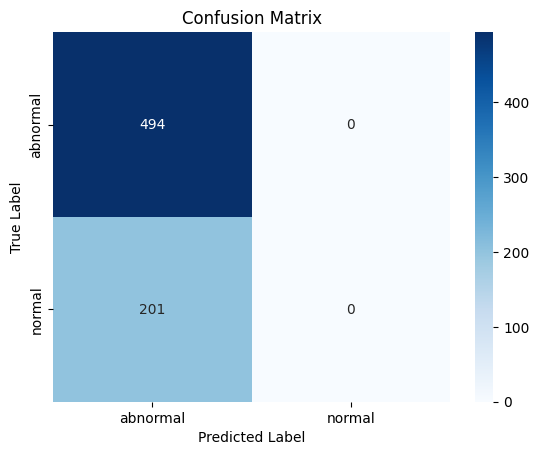

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       494
           1       0.00      0.00      0.00       201

    accuracy                           0.71       695
   macro avg       0.36      0.50      0.42       695
weighted avg       0.51      0.71      0.59       695



c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [6]:
import numpy as np
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have a trained model named 'model' and validation generator 'val_generator'

# Predict the labels on the validation set
y_true_val = validation_generator.classes
y_pred_prob_val = GoogLeNet_PCG.predict(validation_generator)
y_pred_val = np.round(y_pred_prob_val)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
cm_val = confusion_matrix(y_true_val, y_pred_val)

# Visualize the confusion matrix with values
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['abnormal', 'normal'], yticklabels=['abnormal', 'normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_val, y_pred_val))

In [7]:
print(cm_train,cm_val)

[[1978    0]
 [ 804    0]] [[494   0]
 [201   0]]


In [8]:
# Assuming the classes are labeled as 0 and 1
class_0_probabilities = y_pred_prob_val[:, 0]  # Probabilities for class 0
class_1_probabilities = 1 - class_0_probabilities  # Probabilities for class 1

# Print the probabilities for both classes
print("Probabilities for class 0:", class_0_probabilities)
print("Probabilities for class 1:", class_1_probabilities)

Probabilities for class 0: [0.30512255 0.30512008 0.3051155  0.30511937 0.30511624 0.30513662
 0.30511692 0.3051295  0.3051281  0.30513546 0.3051081  0.30513713
 0.30512974 0.30511189 0.30513784 0.30511385 0.305138   0.30511245
 0.305118   0.3051146  0.3051367  0.30513373 0.30514088 0.3051176
 0.3051271  0.30512258 0.30512986 0.3051446  0.3051204  0.30513266
 0.305126   0.30513328 0.30513346 0.30512074 0.30512473 0.3051294
 0.30513668 0.30511832 0.30513412 0.30514196 0.30512756 0.3051278
 0.3051178  0.30511174 0.3051231  0.30511826 0.3051088  0.30510685
 0.30510166 0.3051155  0.305096   0.30509314 0.30509812 0.30510098
 0.30510512 0.30510232 0.3051164  0.3051289  0.3051025  0.30510923
 0.30510807 0.30510828 0.30512896 0.30510607 0.30510765 0.30512178
 0.3051328  0.3051193  0.3051207  0.3051294  0.30512097 0.305115
 0.3051184  0.3051137  0.30511823 0.30511323 0.30511844 0.3051141
 0.30511376 0.30511752 0.3051178  0.30512494 0.3051217  0.30511844
 0.30510983 0.30510205 0.30511978 0.30512

In [9]:
import re

# Open the text document in read mode
with open(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\outputs\GoogLeNet\GoogLeNet_PCG\GoogLeNet_PCG.txt", 'r') as file:
    # Read the entire contents of the file
    text = file.read()

# Regular expression pattern to match accuracy values
pattern1 = r"accuracy: (\d+\.\d+)"
pattern2 = r"val_accuracy: (\d+\.\d+)"
pattern3 = r"loss: (\d+\.\d+)"
pattern4 = r"val_loss: (\d+\.\d+)"


# Find all accuracy values using regex
train_accuracy1 = re.findall(pattern1, text)
val_accuracy = re.findall(pattern2, text)
train_loss1 = re.findall(pattern3, text)
val_loss = re.findall(pattern4, text)

# Convert accuracy values to float
train_accuracy1 = [float(value) for value in train_accuracy1]
val_accuracy = [float(value) for value in val_accuracy]
train_loss1 = [float(value) for value in train_loss1]
val_loss = [float(value) for value in val_loss]

In [16]:
train_accuracy=[]
train_loss=[]
i=-2
while i<67:
    train_accuracy.append(train_accuracy1[i+3])
    train_loss.append(train_loss1[i+3])
    i+=3

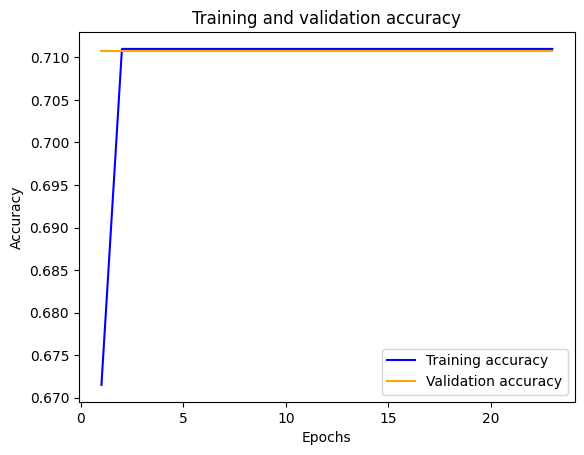

In [18]:
import matplotlib.pyplot as plt
# Plot the epoch vs accuracy curve
epochs = range(1, 24)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

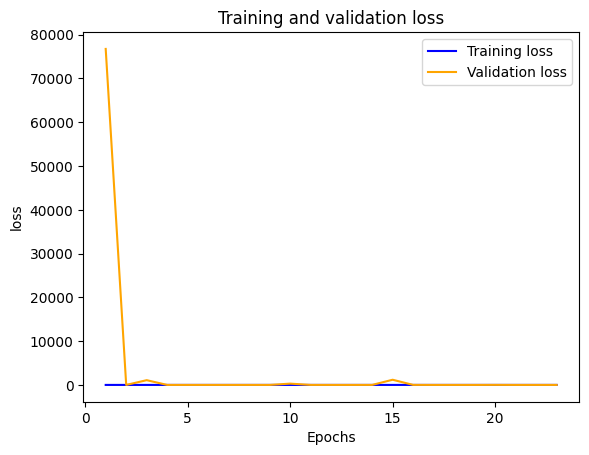

In [28]:
import matplotlib.pyplot as plt
# Plot the epoch vs accuracy curve
epochs = range(1, 24)
plt.plot(epochs, train_loss ,'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
def calculate_metrics(confusion_matrix):
    # Extract values from confusion matrix
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[1][0]
    FN = confusion_matrix[0][1]
    TN = confusion_matrix[1][1]
    
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return precision, recall, f1_score, accuracy,specificity

In [23]:
cm_fused_val= [[494 ,  0],[201 ,  0]]
# Calculate metrics
val_precision, val_recall, val_f1_score, val_accuracy, val_specificity = calculate_metrics(cm_fused_val)

# Print results
print("Precision:", val_precision)
print("Recall (Sensitivity):", val_recall)
print("F1 Score:", val_f1_score)
print("Accuracy:", val_accuracy)
print("specificity:",val_specificity)

Precision: 0.7107913669064748
Recall (Sensitivity): 1.0
F1 Score: 0.8309503784693019
Accuracy: 0.7107913669064748
specificity: 0.0


In [22]:
cm_ecg_train= [[1978 ,   0],[ 804 ,   0]]
# Calculate metrics
train_precision, train_recall, train_f1_score, train_accuracy, train_specificity = calculate_metrics(cm_ecg_train)

# Print results
print("Precision:", train_precision)
print("Recall (Sensitivity):", train_recall)
print("F1 Score:", train_f1_score)
print("Accuracy:", train_accuracy)
print("specificity:",train_specificity)

Precision: 0.710999281092739
Recall (Sensitivity): 1.0
F1 Score: 0.83109243697479
Accuracy: 0.710999281092739
specificity: 0.0


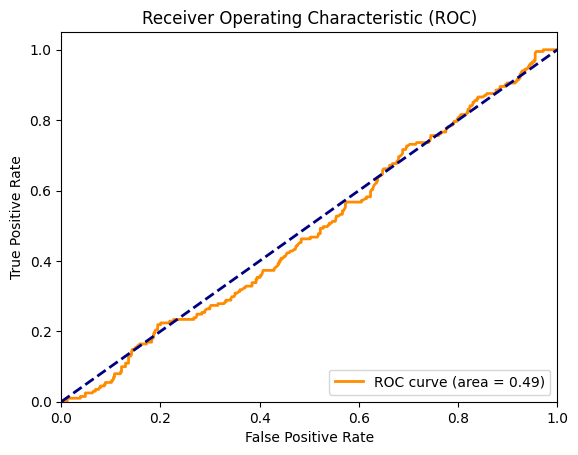

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

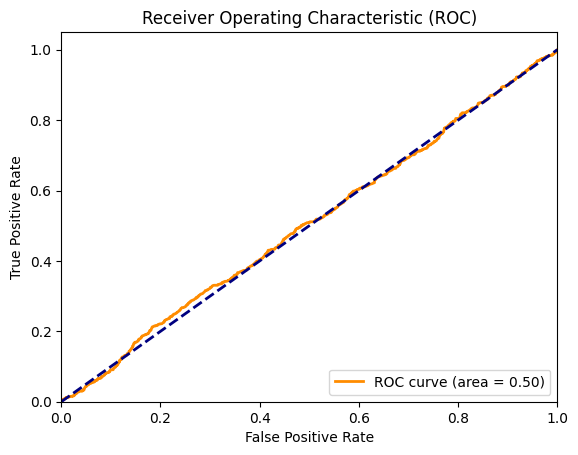

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
y_true_train=train_generator.classes
fpr, tpr, thresholds = roc_curve(y_true_train, y_pred_prob_train)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

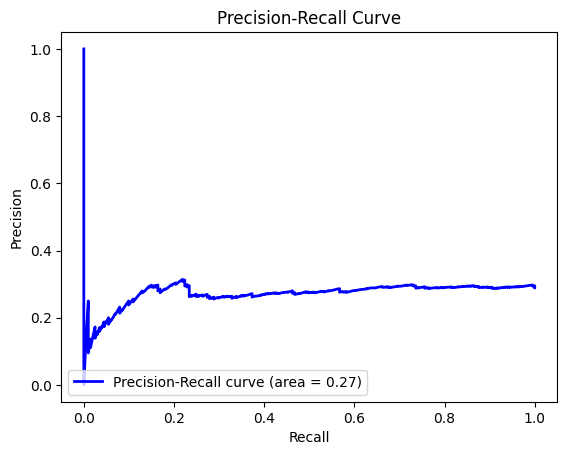

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
y_true_val=validation_generator.classes
precision, recall, thresholds = precision_recall_curve(y_true_val, y_pred_prob_val)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

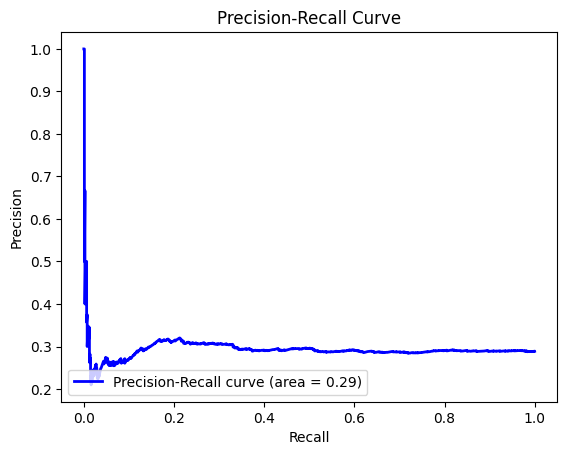

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true_train, y_pred_prob_train)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()